In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Set some parameters
im_width = 256
im_height = 256
border = 5

In [ ]:
#Give Train Image Folder Path
ids = next(os.walk("/content/drive/My Drive/VillageData/patches/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  3566


In [ ]:
X_train = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y_train = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/My Drive/VillageData/patches/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/My Drive/VillageData/patches_gt/images/"+id_[:-3]+'tif', grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
#Give Validation Image Folder Path

ids = next(os.walk("/content/drive/My Drive/VillageData/val_patches/images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))
X_valid = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y_valid = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

No. of images =  322


In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/My Drive/VillageData/val_patches/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/My Drive/VillageData/val_gt/images/"+id_[:-3]+'tif', grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X_valid[n] = x_img/255.0
    y_valid[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


###visualize the images and corresponding masks

Text(0.5, 1.0, 'Buildings')

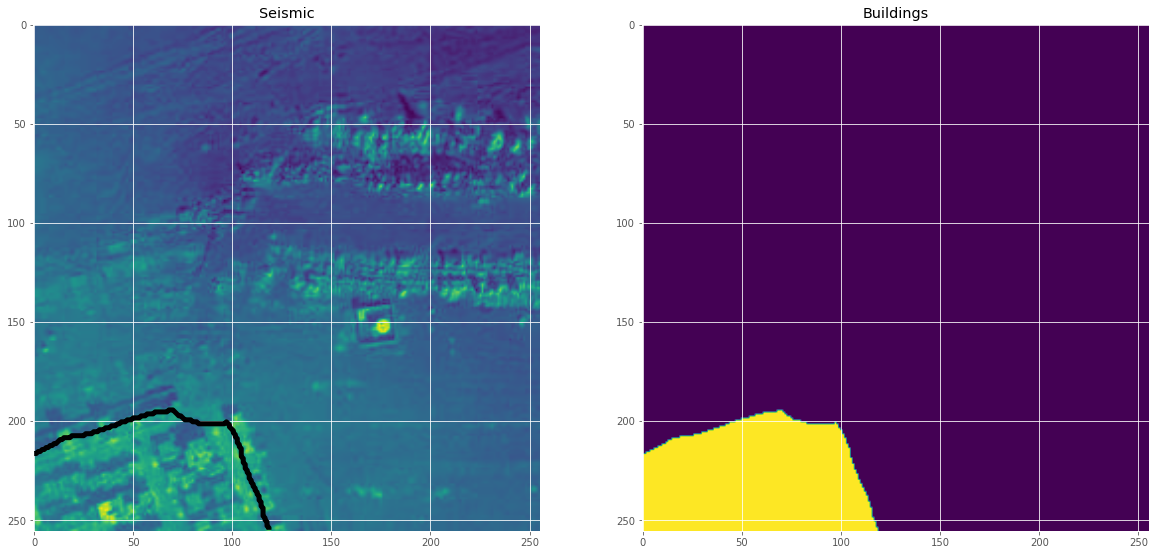

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite')

ax2.imshow(y_train[ix].squeeze(), interpolation = 'bilinear')
ax2.set_title('Buildings')

## Model Training

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3566 samples, validate on 322 samples
Epoch 1/10
3566/3566 [==============================] - 35s 10ms/step - loss: 0.2461 - accuracy: 0.9182 - val_loss: 0.5925 - val_accuracy: 0.8058

Epoch 00001: val_loss improved from inf to 0.59252, saving model to model-tgs-salt.h5
Epoch 2/10
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1763 - accuracy: 0.9343 - val_loss: 0.9047 - val_accuracy: 0.8092

Epoch 00002: val_loss did not improve from 0.59252
Epoch 3/10
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1498 - accuracy: 0.9423 - val_loss: 0.7182 - val_accuracy: 0.8138

Epoch 00003: val_loss did not improve from 0.59252
Epoch 4/10
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1409 - accuracy: 0.9425 - val_loss: 0.6283 - val_accuracy: 0.8293

Epoch 00004: val_loss did not improve from 0.59252
Epoch 5/10
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1360 - accuracy: 0.9448 - val_loss: 0.6360 - val_a

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3566 samples, validate on 322 samples
Epoch 1/50
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1078 - accuracy: 0.9555 - val_loss: 0.7047 - val_accuracy: 0.8294

Epoch 00001: val_loss did not improve from 0.46072
Epoch 2/50
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1155 - accuracy: 0.9527 - val_loss: 0.4971 - val_accuracy: 0.8456

Epoch 00002: val_loss did not improve from 0.46072
Epoch 3/50
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1109 - accuracy: 0.9543 - val_loss: 0.4303 - val_accuracy: 0.8580

Epoch 00003: val_loss improved from 0.46072 to 0.43034, saving model to model-tgs-salt.h5
Epoch 4/50
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1037 - accuracy: 0.9574 - val_loss: 0.4064 - val_accuracy: 0.8654

Epoch 00004: val_loss improved from 0.43034 to 0.40639, saving model to model-tgs-salt.h5
Epoch 5/50
3566/3566 [==============================] - 25s 7ms/step - loss: 0.1007 - a

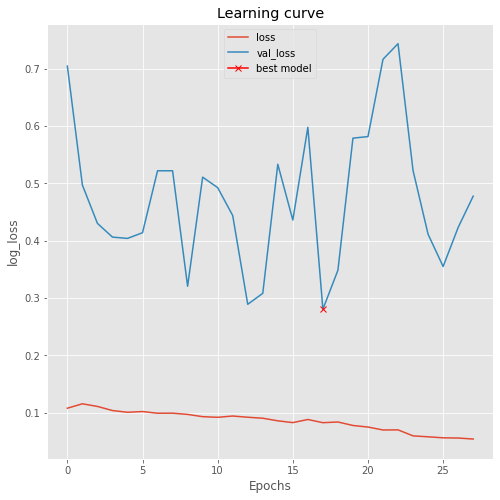

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# load the best model
model.load_weights('unet_50epochs.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

322/322 [==============================] - 1s 2ms/step


[0.2804411072168291, 0.8998314738273621]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

322/322 [==============================] - 1s 2ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

## Prediction

In [ ]:
img = load_img("/content/Peshawar_2-1tile_200-4000.tif", grayscale=True)
x_img = img_to_array(img)
x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
x_img = x_img/255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
# Predict on train, val and test
preds_test = model.predict(x_img.reshape((1,256, 256, 1)), verbose=1)
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 120ms/step


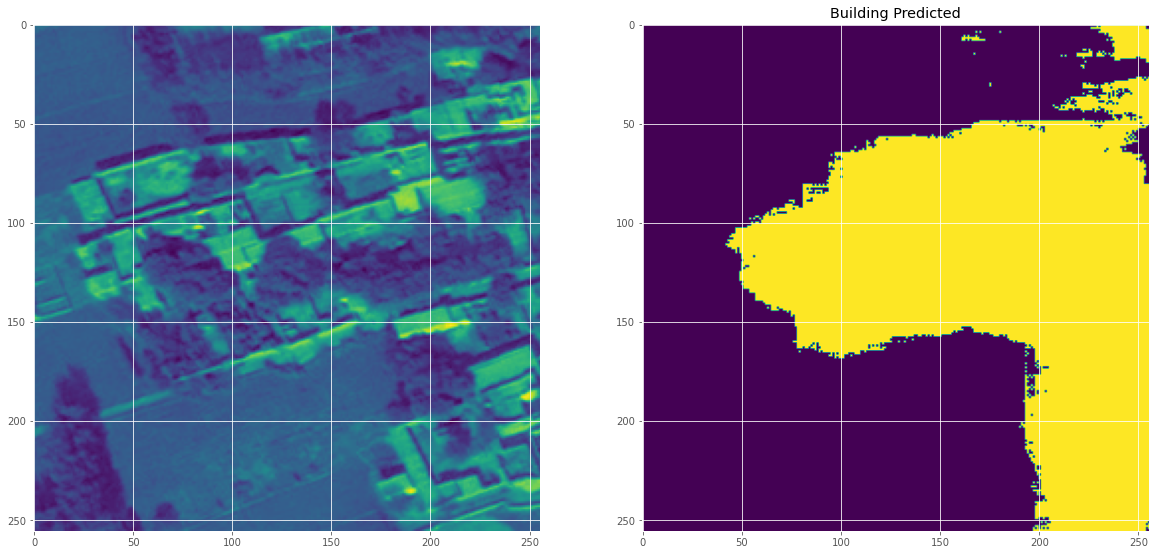

In [ ]:
def plot_sample(X, preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[0, ..., 0])

    ax[1].imshow(preds.squeeze(), vmin=0, vmax=1)
    ax[1].set_title('Building Predicted')

# Check if training data looks all right
plot_sample(x_img.reshape((1,256, 256, 1)), preds_test_t)